### Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph

from optimal_k_selector import OptimalKSelector
from generalized_spectral_analyst import GeneralizedSpectralAnalyst
from graph_perturbator import GraphLaplacianPerturbation, PerturbationMethod

# Plot style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 130

### Load and preprocess the data

In [2]:
df = pd.read_csv("Iris.csv")

print("First 5 rows of the full dataset:")
# display(df.head())

X = df[['SepalLengthCm', 'SepalWidthCm',
              'PetalLengthCm', 'PetalWidthCm']].values
y = df['Species'].astype('category').cat.codes.values

print("\nFull dataset shape (n_samples, n_features):", X.shape)
print("Unique label codes:", np.unique(y))

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

First 5 rows of the full dataset:

Full dataset shape (n_samples, n_features): (150, 4)
Unique label codes: [0 1 2]


### Build KKN and the vectors

In [3]:
# 1. Optimal k selection
# We use the selector to find a k that balances graph connectivity and sparsity
selector = OptimalKSelector(X_scaled)
results = selector.analyze_k_range(k_min=5, k_max=20)
recommendations = selector.recommend_k(results)
k = int(recommendations['overall_best']['k'])

print(f"Optimal k selected: {k}")

# 2. Build the initial k-NN graph using Euclidean distances
# 'mode=distance' is required to calculate the RBF weights later
knn_dist_graph = kneighbors_graph(
    X_scaled,
    n_neighbors=k,
    mode='distance',
    include_self=False
)

# Convert to dense for weight calculations
dist_knn = knn_dist_graph.toarray()

# 3. Handle the "Neighbor Mask"
# kneighbors_graph uses 0.0 for "not a neighbor". We must store where the
# connections are so we don't confuse "far away" with "identical points".
neighbor_mask = dist_knn > 0

# 4. Calculate the RBF Kernel (Affinity Matrix)
# We use the median heuristic for sigma to ensure the kernel scales with the data
nonzero_dist = dist_knn[neighbor_mask]
sigma = np.median(nonzero_dist) if len(nonzero_dist) > 0 else 1.0
print(f"RBF Sigma (Width): {sigma:.4f}")

# W_ij = exp(-d^2 / (2 * sigma^2))
W = np.exp(-(dist_knn ** 2) / (2 * sigma ** 2))

# 5. Clean the Affinity Matrix
# Only keep weights for actual k-neighbors; set everything else to 0
W[~neighbor_mask] = 0.0

# 6. Symmetrize the Graph
# Using 'maximum' ensures that if A is a neighbor of B, they are connected
# regardless of whether the k-NN search was reciprocal.
W = np.maximum(W, W.T)

# 7. Construct the Graph Laplacian
# D is the degree matrix (sum of weights for each node)
# L = D - W is the unnormalized Laplacian
D = np.diag(W.sum(axis=1))
L = D - W

# Verification Prints
print("-" * 30)
print(f"Adjacency (W) Shape: {W.shape}")
print(f"Laplacian (L) Shape: {L.shape}")
print(f"Average degree (sum of weights): {np.mean(W.sum(axis=1)):.4f}")
print(f"Is L symmetric? {np.allclose(L, L.T)}")

Dataset: n=150 samples, d=4 features

Analyzing k ∈ [5, 20] (step=1)...
--------------------------------------------------------------------------------
k=  5 ✓ connected 
k=  6 ✓ connected k=  7 ✓ connected k=  8 ✓ connected k=  9 ✓ connected k= 10 ✓ connected 
k= 11 ✓ connected k= 12 ✓ connected k= 13 ✓ connected k= 14 ✓ connected k= 15 ✓ connected 
k= 16 ✓ connected k= 17 ✓ connected k= 18 ✓ connected k= 19 ✓ connected k= 20 ✓ connected 

--------------------------------------------------------------------------------
Optimal k selected: 20
RBF Sigma (Width): 0.6776
------------------------------
Adjacency (W) Shape: (150, 150)
Laplacian (L) Shape: (150, 150)
Average degree (sum of weights): 13.1615
Is L symmetric? True


### Testing Standard LAPLACE_STANDARD VS FROBENIUS_SCALED vs GAUSSIAN_MECHANISM Pertubation Mechanisms

High Stability (Low Distance): The cluster signal is well-preserved, meaning nodes remain on the correct side of the spectral partition despite privacy protection.

Low Stability (High Distance): The noise has significantly "tilted" or rotated the vector, potentially leading to misclassification in downstream ML tasks.

--- Generalized Structural Analysis Initialized ---
Connected Components (Islands): 1
Fiedler Mode located at Index: 1
Base Algebraic Connectivity (λ₀): 0.000332
Starting perturbation analysis across 10 epsilon levels...


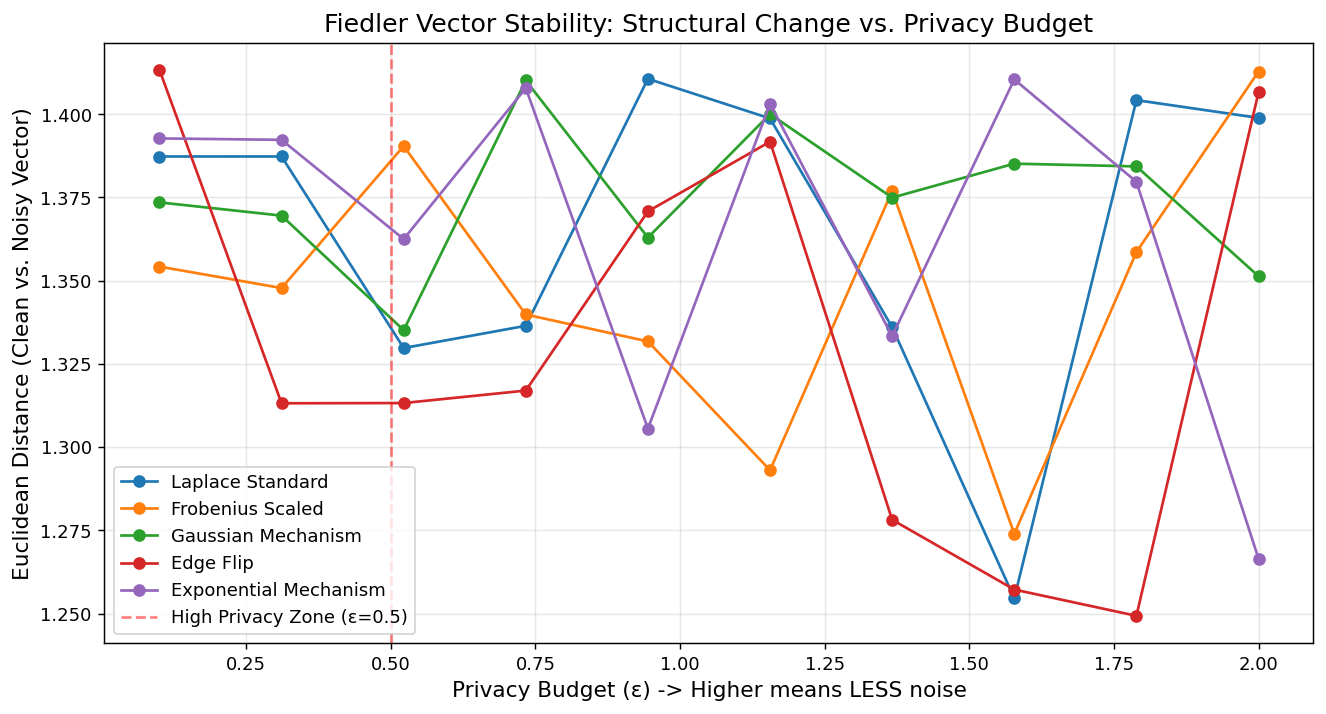


--- Structural Signal Retention ---
method    edge_flip  exponential_mechanism  frobenius_scaled  \
epsilon                                                        
1.155556   0.566667               0.546667          0.586667   
1.366667   0.666667               0.560000          0.513333   
1.577778   0.620000               0.473333          0.566667   
1.788889   0.620000               0.513333          0.526667   
2.000000   0.426667               0.553333          0.506667   

method    gaussian_mechanism  laplace_standard  
epsilon                                         
1.155556                0.54          0.513333  
1.366667                0.48          0.540000  
1.577778                0.52          0.546667  
1.788889                0.54          0.533333  
2.000000                0.48          0.493333  


In [4]:
epsilon_range = np.linspace(0.1, 2.0, 10)  # From high privacy (0.1) to low privacy (2.0)
methods_to_test = [
    PerturbationMethod.LAPLACE_STANDARD,
    PerturbationMethod.FROBENIUS_SCALED,
    PerturbationMethod.GAUSSIAN_MECHANISM,
    PerturbationMethod.EDGE_FLIP,
    PerturbationMethod.EXPONENTIAL_MECHANISM,
]

# Initialize the Perturbator and the Base Analyst
perturbator = GraphLaplacianPerturbation(epsilon_total=max(epsilon_range))
base_analyst = GeneralizedSpectralAnalyst(base_laplacian=L, base_degree_matrix=D)
orig_val, orig_fiedler = base_analyst.get_fiedler_mode()

# 2. Iterative Perturbation Analysis
results_list = []

print(f"Starting perturbation analysis across {len(epsilon_range)} epsilon levels...")

for eps in epsilon_range:
    for method in methods_to_test:
        # We reset the budget for each independent trial to compare methods fairly
        perturbator.reset_budget(new_epsilon=eps)

        # Apply Perturbation to the Matrix Representation (The Laplacian)
        result = perturbator.perturb(L, method=method, epsilon_allocated=eps)

        # Calculate the distance between the Clean and Noisy Fiedler Vectors
        comparison = perturbator.compare_fiedler_vectors(L, result.perturbed_laplacian)

        results_list.append({
            'epsilon': eps,
            'method': method.value,
            'dist': comparison['vector_euclidean_distance'],
            'cosine': comparison['vector_cosine_similarity'],
            'agreement': comparison['partition_agreement']
        })

# 3. Visualization of Structural Stability
df_results = pd.DataFrame(results_list)

plt.figure(figsize=(12, 6))

for method in methods_to_test:
    method_data = df_results[df_results['method'] == method.value]
    plt.plot(method_data['epsilon'], method_data['dist'], marker='o', label=method.value.replace('_', ' ').title())

# Adding Research Context to Plot
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='High Privacy Zone (ε=0.5)')
plt.title("Fiedler Vector Stability: Structural Change vs. Privacy Budget", fontsize=14)
plt.xlabel("Privacy Budget (ε) -> Higher means LESS noise", fontsize=12)
plt.ylabel("Euclidean Distance (Clean vs. Noisy Vector)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# 4. Partition Agreement Summary
print("\n--- Structural Signal Retention ---")
pivot_table = df_results.pivot(index='epsilon', columns='method', values='agreement')
print(pivot_table.tail(5)) # Show results for the most stable end (highest epsilon)

<>:82: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
<>:86: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
<>:82: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
<>:86: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\e"? A raw string is also an option.
/tmp/ipykernel_45314/3793370384.py:82: SyntaxWarning: "\l" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\l"? A raw string is also an option.
  axes[1, 1].set_title("D. Connectivity Shift ($|\lambda_2 - \lambda_{2noisy}|$)")
/tmp/ipykernel_45314/3793370384.py:86: SyntaxWarning: "\e" is an invalid escape sequence. Such sequences will not w

Starting multi-metric analysis across 10 epsilon levels...
noise scale: 20.0
noise scale: 3511.118467543846
noise scale: 96.89610525210779
noise scale: 0.830060993980332
noise scale: 77.1039460336533
noise scale: 6.428571428571429
noise scale: 1128.5737931390934
noise scale: 31.145176688177504
noise scale: 0.7213923271315346
noise scale: 23.555825996678568
noise scale: 3.829787234042553
noise scale: 672.3418342105236
noise scale: 18.5545733461483
noise scale: 0.6351218387113274
noise scale: 15.046239248403932
noise scale: 2.7272727272727275
noise scale: 478.7888819377972
noise scale: 13.213105261651062
noise scale: 0.5477330322537163
noise scale: 10.460599940628246
noise scale: 2.1176470588235294
noise scale: 371.76548479876016
noise scale: 10.259587614929059
noise scale: 0.4845268499613166
noise scale: 7.98214091619156
noise scale: 1.7307692307692306
noise scale: 303.8467904605251
noise scale: 8.38523987758625
noise scale: 0.41913026806889164
noise scale: 6.559138301881325
noise scale

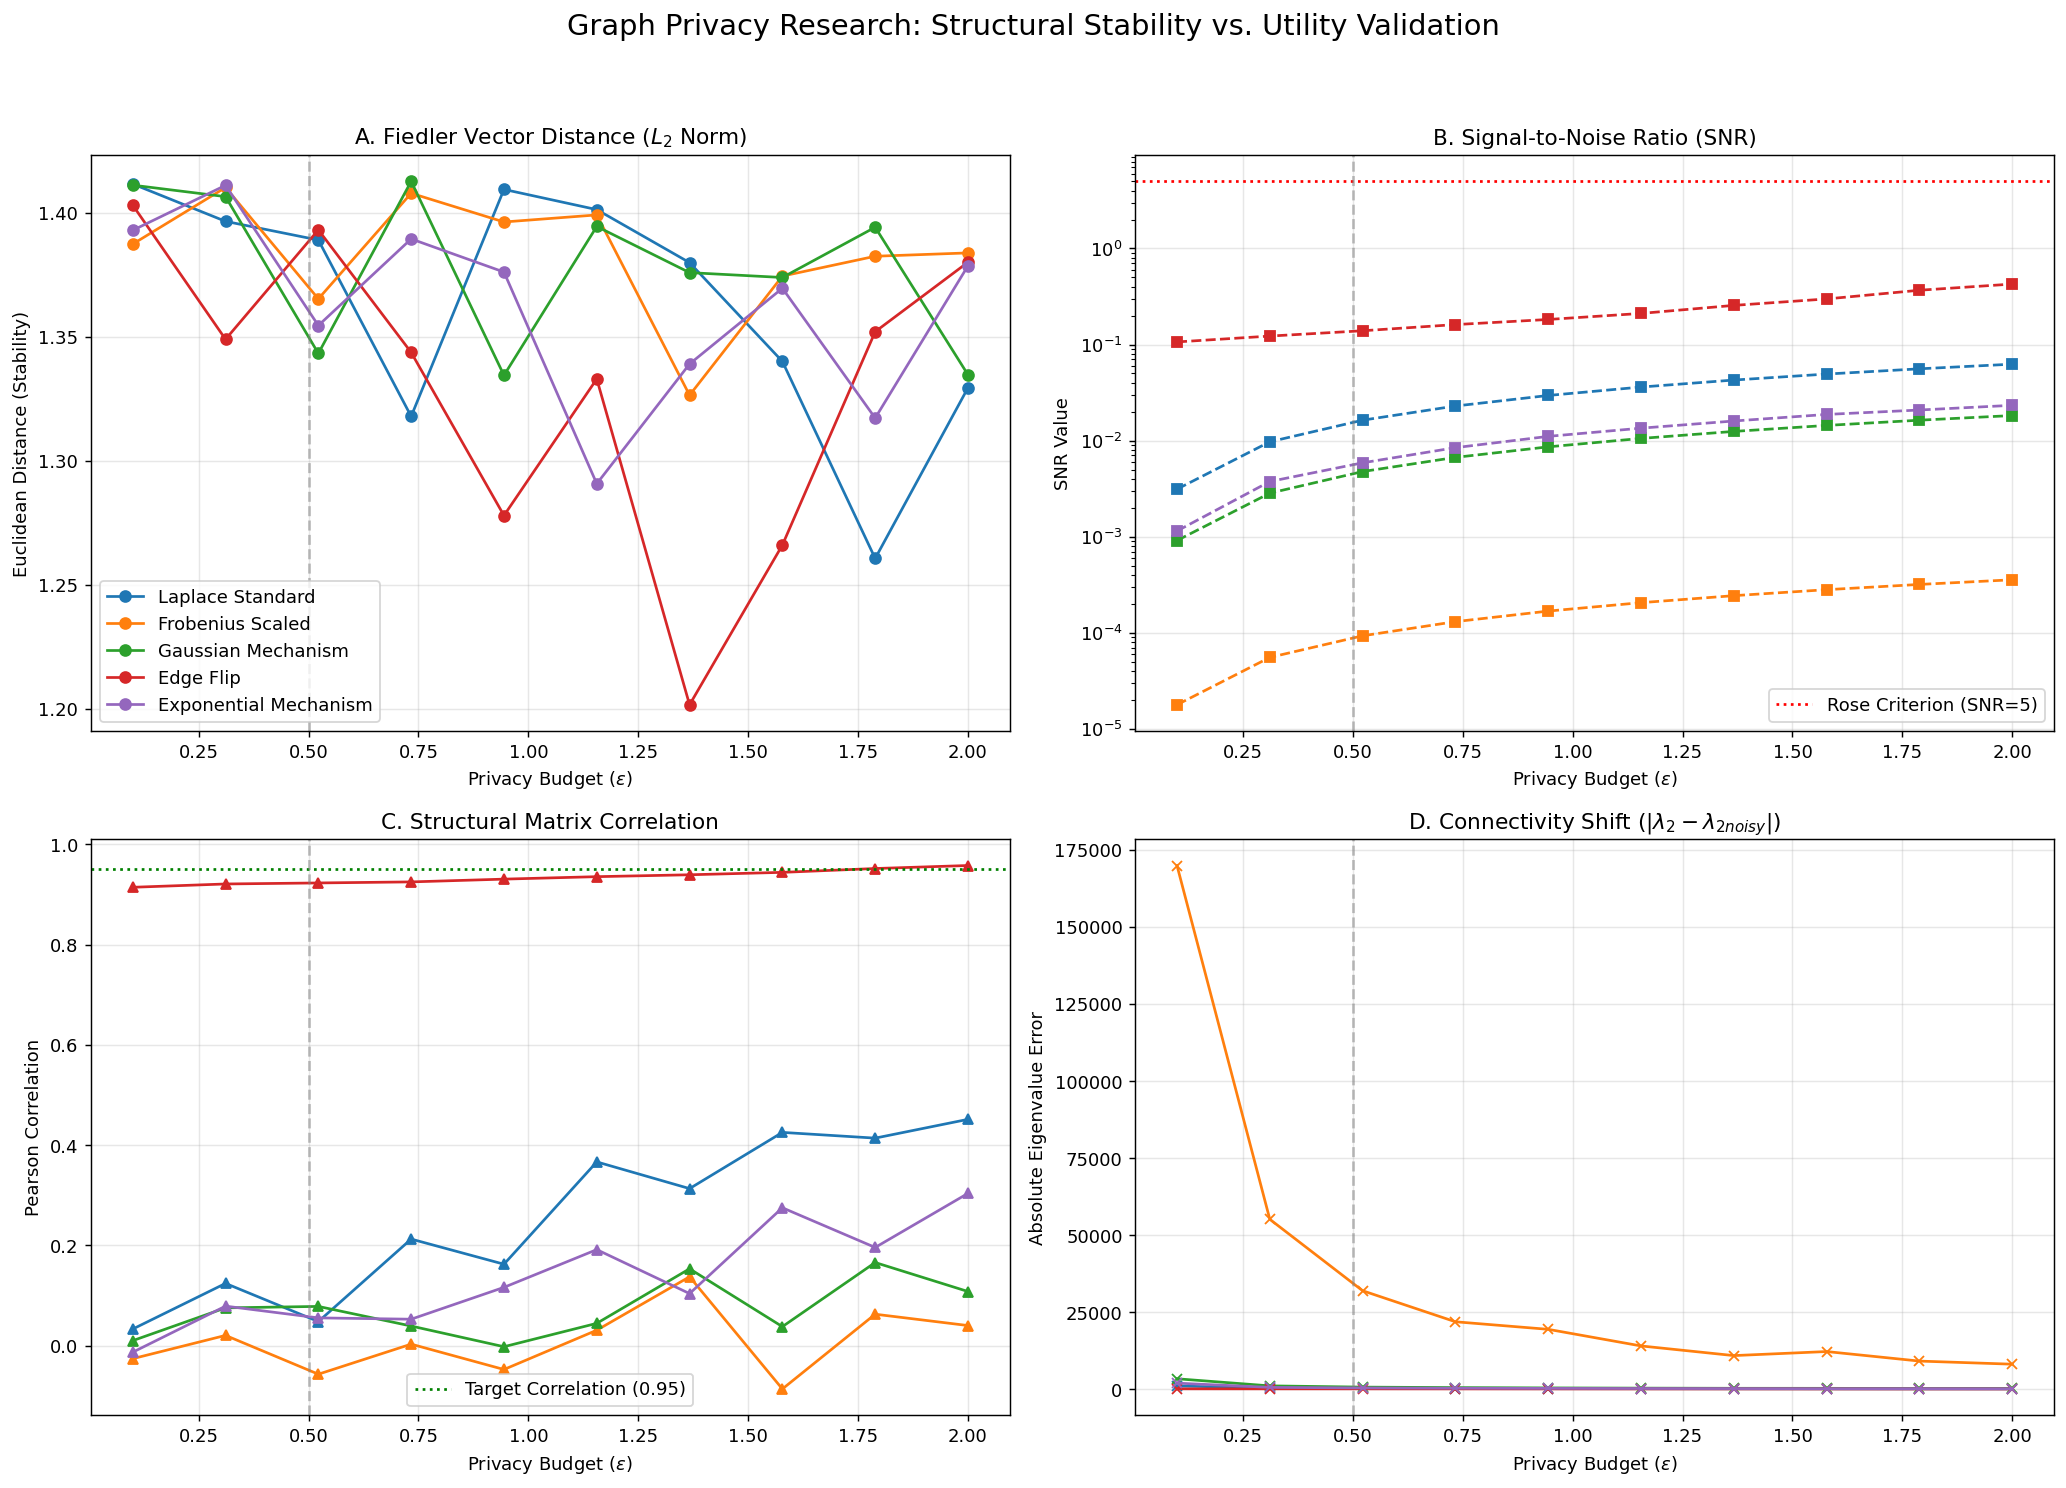

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Setup Parameters
epsilon_range = np.linspace(0.1, 2.0, 10)
methods_to_test = [
    PerturbationMethod.LAPLACE_STANDARD,
    PerturbationMethod.FROBENIUS_SCALED,
    PerturbationMethod.GAUSSIAN_MECHANISM,
    PerturbationMethod.EDGE_FLIP,
    PerturbationMethod.EXPONENTIAL_MECHANISM,
]

perturbator = GraphLaplacianPerturbation(epsilon_total=max(epsilon_range))
results_list = []

print(f"Starting multi-metric analysis across {len(epsilon_range)} epsilon levels...")

# 2. Iterative Analysis Loop
for eps in epsilon_range:
    for method in methods_to_test:
        perturbator.reset_budget(new_epsilon=eps)

        # Apply Perturbation
        result = perturbator.perturb(L, method=method, epsilon_allocated=eps)
        print("noise scale:", result.noise_scale)

        # Calculate Utility Metrics (Mivule 2013 / Rose 1948)
        utility = perturbator.validate_utility(L, result.perturbed_laplacian, result.noise_scale, method=method)

        # Calculate Fiedler Stability (Greenbaum 2020)
        fiedler_comp = perturbator.compare_fiedler_vectors(L, result.perturbed_laplacian)

        results_list.append({
            'epsilon': eps,
            'method': method.value,
            'dist': fiedler_comp['vector_euclidean_distance'],
            'snr': utility.get('snr', 0),
            'correlation': utility['structural_correlation'],
            'connectivity_error': fiedler_comp['connectivity_shift'],
            'agreement': fiedler_comp['partition_agreement']
        })

df_results = pd.DataFrame(results_list)

# 3. Visualization Suite
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Graph Privacy Research: Structural Stability vs. Utility Validation", fontsize=16)

# Plot A: Fiedler Vector Stability (Structural Signal)
for method in methods_to_test:
    data = df_results[df_results['method'] == method.value]
    axes[0, 0].plot(data['epsilon'], data['dist'], marker='o', label=method.value.replace('_', ' ').title())
axes[0, 0].set_title("A. Fiedler Vector Distance ($L_2$ Norm)")
axes[0, 0].set_ylabel("Euclidean Distance (Stability)")
axes[0, 0].legend()

# Plot B: Signal-to-Noise Ratio (Rose Criterion)
for method in methods_to_test:
    data = df_results[df_results['method'] == method.value]
    axes[0, 1].plot(data['epsilon'], data['snr'], marker='s', linestyle='--')
axes[0, 1].axhline(y=5.0, color='r', linestyle=':', label='Rose Criterion (SNR=5)')
axes[0, 1].set_title("B. Signal-to-Noise Ratio (SNR)")
axes[0, 1].set_ylabel("SNR Value")
axes[0, 1].set_yscale('log') # SNR often spans orders of magnitude
axes[0, 1].legend()

# Plot C: Structural Correlation (Mivule Validation)
for method in methods_to_test:
    data = df_results[df_results['method'] == method.value]
    axes[1, 0].plot(data['epsilon'], data['correlation'], marker='^')
axes[1, 0].axhline(y=0.95, color='g', linestyle=':', label='Target Correlation (0.95)')
axes[1, 0].set_title("C. Structural Matrix Correlation")
axes[1, 0].set_ylabel("Pearson Correlation")
axes[1, 0].legend()

# Plot D: Eigenvalue Shift (Algebraic Connectivity)
for method in methods_to_test:
    data = df_results[df_results['method'] == method.value]
    axes[1, 1].plot(data['epsilon'], data['connectivity_error'], marker='x')
axes[1, 1].set_title("D. Connectivity Shift ($|\lambda_2 - \lambda_{2noisy}|$)")
axes[1, 1].set_ylabel("Absolute Eigenvalue Error")

for ax in axes.flat:
    ax.set_xlabel("Privacy Budget ($\epsilon$)")
    ax.grid(True, alpha=0.3)
    ax.axvline(x=0.5, color='grey', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()